In [2]:
import json
import threading
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from urllib.request import urlopen
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3

DATA_DIR = "../data/"
NUM_CLASSES = 228
IMAGE_SIZE = 148

C:\Users\matt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
with open(DATA_DIR + "train.json") as train, open(DATA_DIR + "test.json") as test, open(DATA_DIR + "validation.json") as validation:
    train_json = json.load(train)
    test_json = json.load(test)
    validation_json = json.load(validation)
    
train_urls = [obj['url'] for obj in train_json['images']]
test_urls = [obj['url'] for obj in test_json['images']]
validation_urls = [obj['url'] for obj in validation_json['images']]

print(train_urls[:3])
print(test_urls[:3])
print(validation_urls[:3])

['https://contestimg.wish.com/api/webimage/570f35feb2f4b95d223aa9b1-large', 'https://contestimg.wish.com/api/webimage/5468f1c0d96b290ff8e5c805-large', 'https://contestimg.wish.com/api/webimage/546410237d57f323e72ca414-large']
['https://contestimg.wish.com/api/webimage/568e16a72dfd0133cb3f7a79-large', 'https://contestimg.wish.com/api/webimage/5452f9925f313f502bf119ff-large', 'https://contestimg.wish.com/api/webimage/540584051d2d435c5a300a82-large']
['https://contestimg.wish.com/api/webimage/568e16a72dfd0133cb3f7a79-large', 'https://contestimg.wish.com/api/webimage/5452f9925f313f502bf119ff-large', 'https://contestimg.wish.com/api/webimage/540584051d2d435c5a300a82-large']


In [4]:
def generate_label_array(json_obj):
    result = []
    for data in json_obj['annotations']:
        temp_array = [0] * NUM_CLASSES
        for elem in data['labelId']:
            temp_array[int(elem) - 1] = 1
        result.append(temp_array)
    return np.array(result)

train_labels = generate_label_array(train_json)
validation_labels = generate_label_array(validation_json)

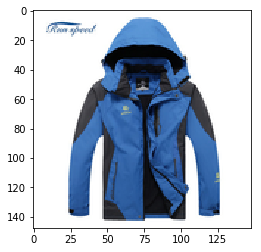

In [5]:
TARGET_SIZE=(IMAGE_SIZE,IMAGE_SIZE)

rand_img = np.random.randint(0, len(train_urls))
img_label = np.array(train_labels[rand_img]).reshape(1, 228)
img_path = train_urls[rand_img]
img_file = urlopen(img_path)
image = Image.open(img_file)
image_resized = image.resize(TARGET_SIZE, Image.ANTIALIAS)
image_resized.thumbnail(TARGET_SIZE, Image.ANTIALIAS)
plt.imshow(np.asarray(image_resized))
plt.show()

In [7]:
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self): # Py3
        return next(self.it)

    def next(self):     # Py2
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """
    A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
def batch_generator(img_array, label_array, batch_size=32, target_size=(IMAGE_SIZE,IMAGE_SIZE)):  
    while True:
        X = []
        y = []
        for i in range(batch_size):
            rand_img = np.random.randint(0, len(img_array))
            img_label = np.array(label_array[rand_img]).reshape(1, NUM_CLASSES)
            img_path = img_array[rand_img]
            image = url_to_image(img_path, target_size)
            X_batch = np.asarray(image).reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
            X_batch = X_batch / 255.0
            X.append(X_batch)
            y.append(img_label)
        yield np.array(X).reshape(batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), np.array(y).reshape(batch_size, NUM_CLASSES)

def url_to_image(url, target_size):
    try:
        resp = urllib.urlopen(url)
        image = np.asarray(bytearray(resp.read()), dtype='uint8')
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    except:
        output = [1]*(IMAGE_SIZE*IMAGE_SIZE*3)
        output = np.array(output).reshape(IMAGE_SIZE,IMAGE_SIZE,3).astype('uint8')
        image = Image.fromarray(output).convert('RGB')
    image_resized = image.resize(target_size, Image.ANTIALIAS)
    image_resized.thumbnail(target_size, Image.ANTIALIAS)
    return image_resized

In [11]:
conv_base = VGG16(
    weights='imagenet',
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top = False,
    classes = NUM_CLASSES
)

model = Sequential()
model.add(conv_base)
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.3))
model.add(Dense(30, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(NUM_CLASSES, activation='softmax'))
conv_base.trainable = False
print(model.summary())

# model = Sequential()
# model.add(Conv2D(filters=30, kernel_size=3, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# model.add(Dropout(0.4))
# model.add(GlobalMaxPooling2D())
# model.add(Dropout(0.3))
# model.add(Dense(30, activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(Dense(NUM_CLASSES, activation='softmax'))
# model.summary()

# j = int(np.sqrt(NUM_CLASSES))
# i = int(np.ceil(1. * NUM_CLASSES / j))
# fig = plt.figure(1, figsize=(16, 16))
# grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)

# for i, (img_path, labels) in enumerate(subset[['imagePath', 'labelId']].values):
#     ax = grid[i]
#     img = import_image(img_path)
#     ax.imshow(img / 255.)
#     x = preprocess_input(np.expand_dims(img.copy(), axis=0))
#     preds = model.predict(x)
#     _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
#     ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
#     ax.text(10, 200, 'LABEL: %s' % labels, color='k', backgroundcolor='w', alpha=0.8)
#     ax.axis('off')
# plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                15390     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 228)               7068      
Total params: 14,737,146
Trainable params: 22,458
Non-trainable params: 14,714,688
___________________________________________________________

In [ ]:
EPOCHS = 1
BATCH = 500
STEPS = len(train_urls) // BATCH

train_url_subset = train_urls[:200000]
train_label_subset = train_labels[:200000]

train_gen = batch_generator(train_urls, train_labels, batch_size = BATCH)
val_gen = batch_generator(validation_urls, validation_labels, batch_size = BATCH)

model.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy']
)

checkpointer = ModelCheckpoint(
    filepath='model.best.hdf5', 
    verbose=1,
    save_best_only=True
)

history = model.fit_generator(
    generator = train_gen,
    validation_data = val_gen,
    epochs = EPOCHS,
    steps_per_epoch = STEPS,
    validation_steps = 1,
)

Epoch 1/1
   4/2029 [..............................] - ETA: 43:08:26 - loss: 31.8481 - acc: 0.0125